***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


In [4]:
SEED = 19
SUB_NBR = "10"

***

In [5]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats
import time

import category_encoders as ce
import lightgbm as lgb
from tqdm import tqdm
from tsforest.forecast import LightGBMForecaster
import optuna

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

In [6]:
def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
class RMSSE():
    def __init__(self, valid_dataframe, scales_dataframe):
        self.valid_dataframe = valid_dataframe
        self.scales_dataframe = scales_dataframe
        self.apply_inverse = False
        if set(["y_mean","y_std"]) <= set(valid_dataframe.columns):
            self.apply_inverse = True

    def _evaluate(self, predictions):
        valid_dataframe = self.valid_dataframe.copy()
        if not self.apply_inverse:  
            valid_dataframe["ypred"] = predictions
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y-ypred)**2")
        else:
            valid_dataframe["ypred"] = valid_dataframe["y_std"]*predictions + valid_dataframe["y_mean"]
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y_raw-ypred)**2")
        mse = valid_dataframe.groupby("sku")["sq_error"].mean().reset_index(name="mse")
        mrg = pd.merge(mse, self.scales_dataframe, how="inner", on="sku")
        return mrg.eval("sqrt(mse)/scale").mean()

    def evaluate(self, ypred, dtrain):
        metric = self._evaluate(ypred)
        return "rmsse", metric, False

In [8]:
def ranked_probability_score(y_true, y_pred):
    """
    Input
        y_true: np.array of shape 30. 
        y_pred: np.array of shape 30. 
    """
    return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def scoring_function(y_true, y_pred):
    """
    Input
        y_true: List of Ints of shape Nx1. Contain the target_stock
        y_pred: List of float of shape Nx30. Contain the prob for each day
    """
    y_true_one_hot = np.zeros_like(y_pred, dtype=np.float64)
    y_true_one_hot[range(len(y_true)), y_true-1] = 1
    return ranked_probability_score(y_true_one_hot, y_pred)

In [9]:
def binarize_predictions(dataframe):
    dataframe = dataframe.copy()
    dataframe["pred_bin"] = -1
    bin_limits = np.arange(1.5, 30, 1.)
    
    cut_left = -np.inf
    for cut_right in bin_limits:
        idx = dataframe.query("@cut_left <= pred < @cut_right").index
        dataframe.loc[idx, "pred_bin"] = int(cut_right)
        cut_left = cut_right
        
    idx = dataframe.query("pred >= @cut_right").index
    dataframe.loc[idx, "pred_bin"] = 30
    
    return dataframe

***
## loading data for assessment

In [10]:
if ASSESS:
    dataset = (
        pd.read_parquet(f"{input_path}/train-m2.parquet")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )

dataset["nrows"] = dataset.groupby("sku")["ds"].transform("count")
print(dataset.sku.nunique())
print(dataset.query("nrows == 30").sku.nunique())

531832
500404


In [11]:
# just for assessment
dataset = (
    dataset
    .query("nrows == 30")
    .query("ds in ('2021-02-01', '2021-03-02')")
    .reset_index(drop=True)
)
print(len(dataset))

skus_to_remove = dataset.query("inventory_days > 30").sku.unique()
dataset = dataset.query("sku not in @skus_to_remove").reset_index(drop=True)
print(len(dataset))

1000808
544260


In [12]:
train_dset = dataset.query("ds == '2021-02-01'").reset_index(drop=True)
valid_dset = dataset.query("ds == '2021-03-02'").reset_index(drop=True)

In [13]:
train_dset.sku.nunique()

272130

In [14]:
valid_dset.sku.nunique()

272130

In [15]:
numeric_cols = [
    "current_price",
    "listing_type_classic",
    "listing_type_premium",
    "shipping_logistic_type_fulfillment",
    "shipping_logistic_type_cross_docking",
    "shipping_logistic_type_drop_off",
    "shipping_payment_free_shipping",
    "shipping_payment_paid_shipping",
    "minutes_active",
    "weekday_1",
    "weekday_2",
    "weekday_3",
    "weekday_4",
    "weekday_5",
    "weekday_6",
    "weekday_7",
    #"q_mean",
    #"q_std",
    "target_stock",   
]
print("number of numeric:", len(numeric_cols))

categs_cols = [
    #"sku",
    "item_domain_id",
    #"item_id",
    #"site_id",
    "product_id",
    #"product_family_id",  
]
print("number of categs", len(categs_cols))

categs_to_encode = [
    #"sku",
    #"item_id",
    #"product_family_id",
]

target = "inventory_days"

input_cols = numeric_cols + categs_cols
print("total feats:", len(input_cols))

number of numeric: 17
number of categs 2
total feats: 19


In [16]:
train_dset.loc[:,categs_cols].nunique()

item_domain_id    7553
product_id        6445
dtype: int64

In [17]:
encoder = ce.OrdinalEncoder()
train_dset[categs_cols] = encoder.fit_transform(train_dset[categs_cols])
valid_dset[categs_cols] = encoder.transform(valid_dset[categs_cols])

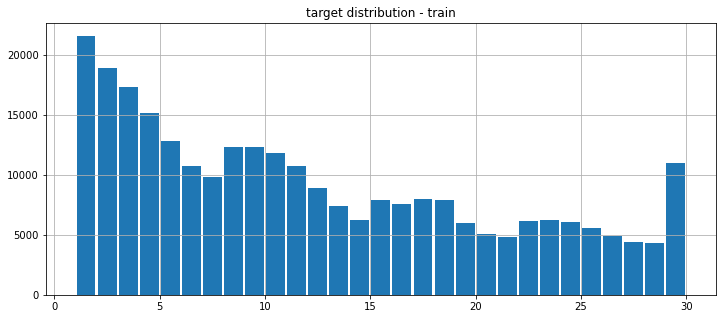

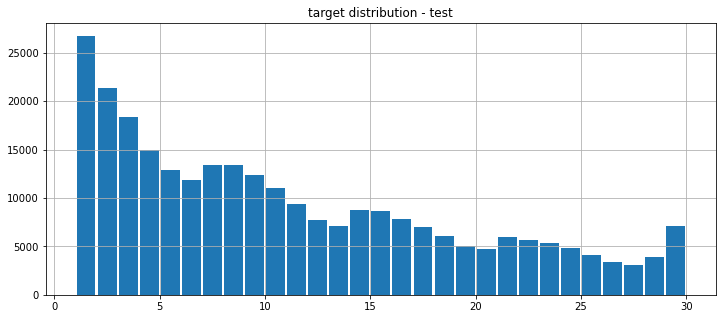

In [18]:
plt.figure(figsize=(12,5))
plt.hist(train_dset[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - train")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(valid_dset[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - test")
plt.grid()
plt.show()

***
## model training: assessment

In [19]:
model_params = {
    'objective': 'huber',
    'alpha': 1.5,
    'metric': 'l1',
    'max_bin': 255,
    'num_leaves': 31,
    'min_data_in_leaf': 100,
    'learning_rate': 0.025,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.95,
    'bagging_freq':1,
    'lambda_l1':10.,
    'lambda_l2':10.,
    'max_cat_threshold': 64,
    'cat_l2': 50,
    'cat_smooth': 50,
    'boost_from_average': True,
    'bin_construct_sample_cnt':20000000,
    'force_row_wise': True,
    'deterministic':True,
    'seed':SEED,
    'feature_pre_filter': True,
    'first_metric_only': True,
}

------------------------------------------------------------------------------------------
Preparing model for site: MLA
[LightGBM] [Info] Total Bins 2182
[LightGBM] [Info] Number of data points in the train set: 24051, number of used features: 12
[LightGBM] [Info] Start training from score 11.353166
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l1: 6.50121	valid_1's l1: 7.14113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's l1: 6.29328	valid_1's l1: 6.92524
[150]	valid_0's l1: 6.10352	valid_1's l1: 6.72916
[200]	valid_0's l1: 5.95992	valid_1's l1: 6.57732
[250]	valid_0's l1: 5.84731	valid_1's l1: 6.45093
[300]	valid_0's l1: 5.76295	valid_1's l1: 6.34686
[350]	valid_0's l1: 5.70249	valid_1's l1: 6.26393
[400]	valid_0's l1: 5.66032	valid_1's l1: 6.19835
[450]	valid_0's l1: 5.63183	valid_1's l1: 6.14618
[500]	valid_0's l1: 5.61333	valid_1's l1: 6.10409
[550]	valid_0's l1: 5.6017	valid_1's l1: 6.06884
[600]	valid_0'

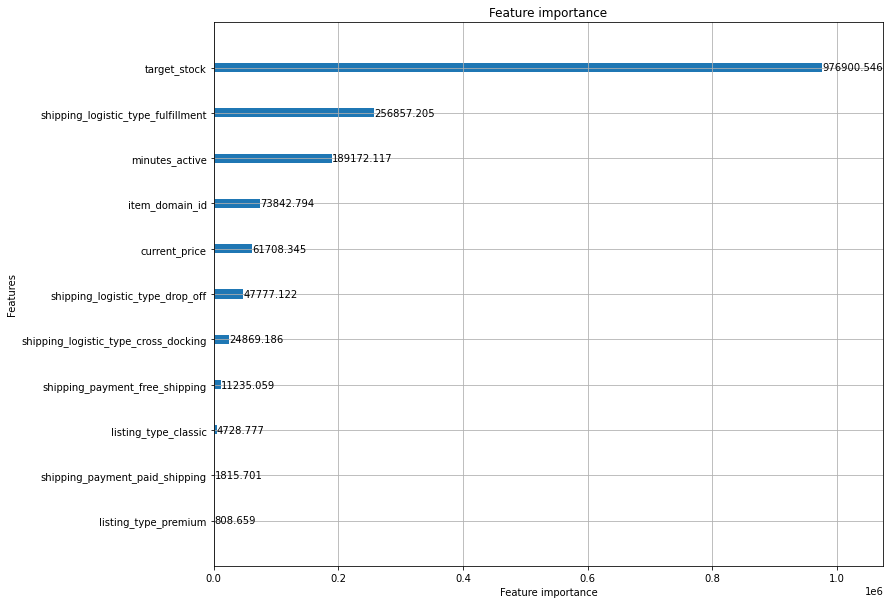

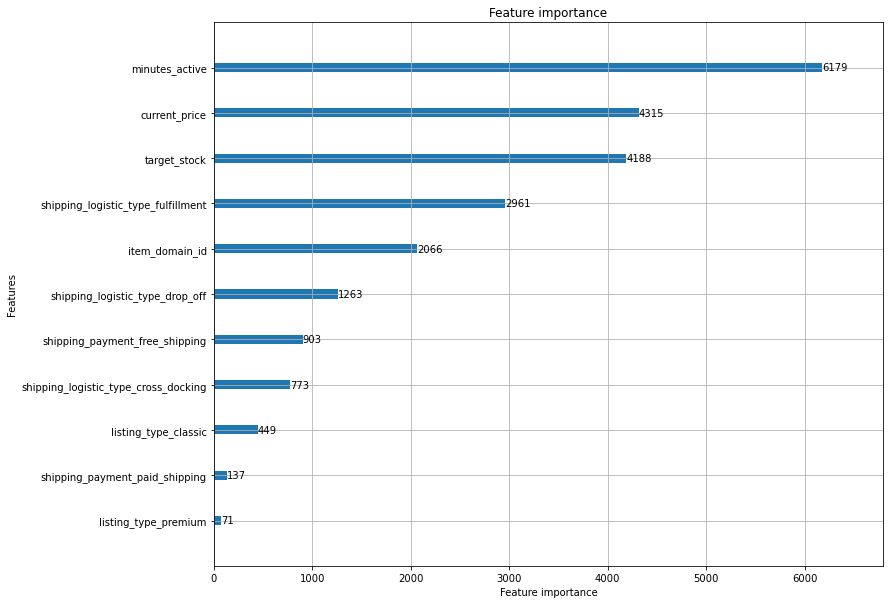

------------------------------------------------------------------------------------------
Preparing model for site: MLB
[LightGBM] [Info] Total Bins 3353
[LightGBM] [Info] Number of data points in the train set: 135858, number of used features: 12
[LightGBM] [Info] Start training from score 11.973428
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l1: 6.86747	valid_1's l1: 7.05604
[100]	valid_0's l1: 6.67266	valid_1's l1: 6.85626
[150]	valid_0's l1: 6.49135	valid_1's l1: 6.67176
[200]	valid_0's l1: 6.35156	valid_1's l1: 6.52573
[250]	valid_0's l1: 6.23632	valid_1's l1: 6.40288
[300]	valid_0's l1: 6.14951	valid_1's l1: 6.30538
[350]	valid_0's l1: 6.0849	valid_1's l1: 6.22879
[400]	valid_0's l1: 6.03702	valid_1's l1: 6.16806
[450]	valid_0's l1: 6.00482	valid_1's l1: 6.12214
[500]	valid_0's l1: 5.98069	valid_1's l1: 6.08468
[550]	valid_0's l1: 5.9655	valid_1's l1: 6.05531
[600]	valid_0's l1: 5.95598	valid_1's l1: 6.03173
[650]	valid_0's l1: 5.94925	valid_1's l

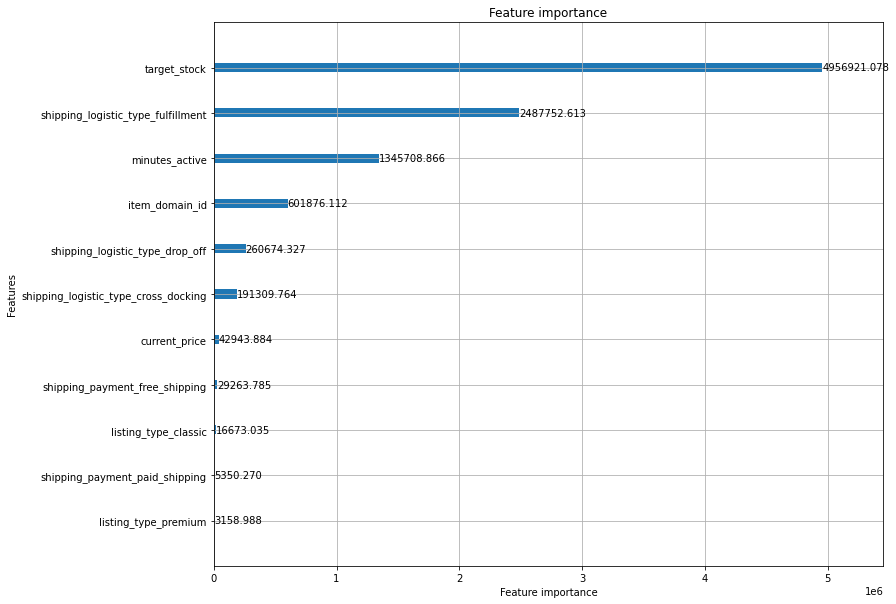

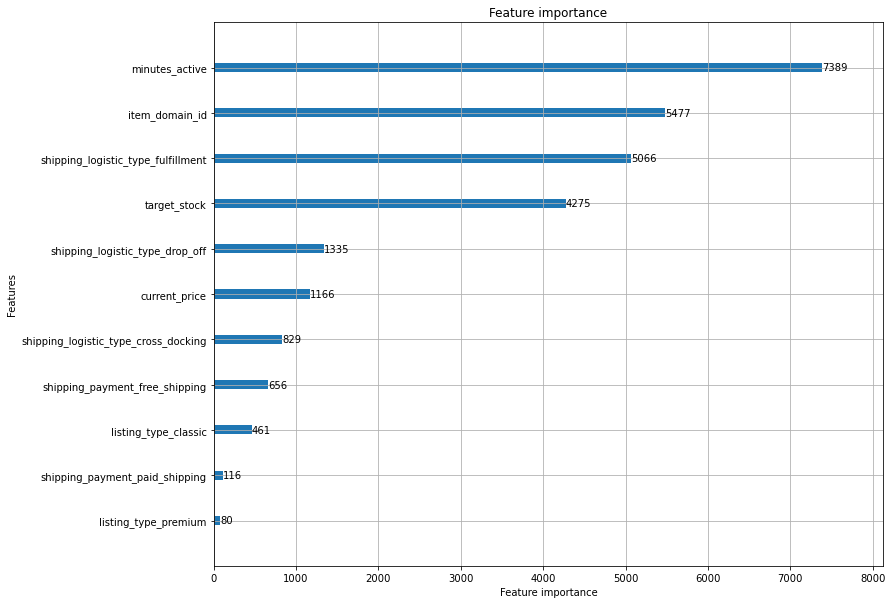

------------------------------------------------------------------------------------------
Preparing model for site: MLM
[LightGBM] [Info] Total Bins 3244
[LightGBM] [Info] Number of data points in the train set: 112221, number of used features: 12
[LightGBM] [Info] Start training from score 11.551822
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l1: 6.81035	valid_1's l1: 6.94661
[100]	valid_0's l1: 6.62367	valid_1's l1: 6.73926
[150]	valid_0's l1: 6.44965	valid_1's l1: 6.55008
[200]	valid_0's l1: 6.31244	valid_1's l1: 6.39925
[250]	valid_0's l1: 6.20249	valid_1's l1: 6.2762
[300]	valid_0's l1: 6.11813	valid_1's l1: 6.17614
[350]	valid_0's l1: 6.05832	valid_1's l1: 6.10045
[400]	valid_0's l1: 6.0165	valid_1's l1: 6.04544
[450]	valid_0's l1: 5.98639	valid_1's l1: 6.00216
[500]	valid_0's l1: 5.96562	valid_1's l1: 5.96758
[550]	valid_0's l1: 5.95407	valid_1's l1: 5.94147
[600]	valid_0's l1: 5.94595	valid_1's l1: 5.92056
[650]	valid_0's l1: 5.93942	valid_1's l

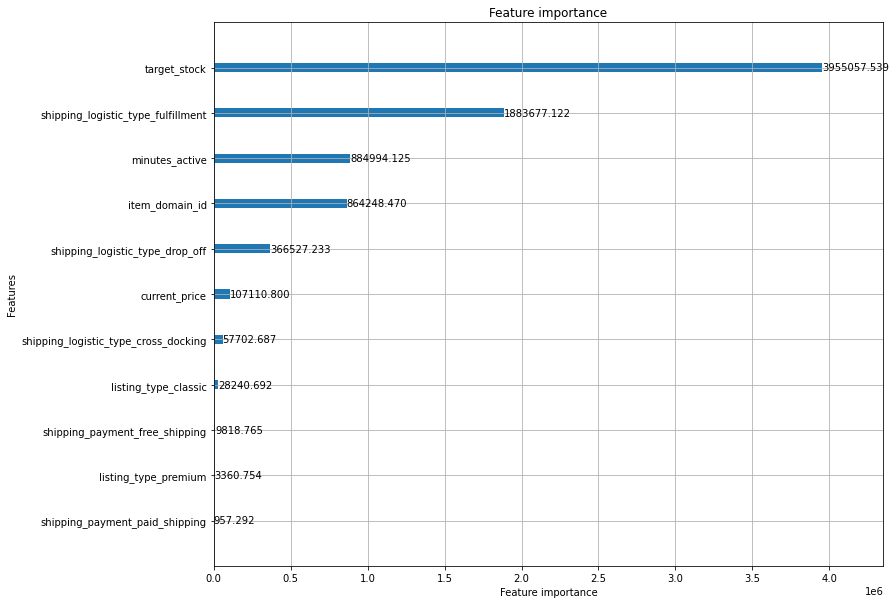

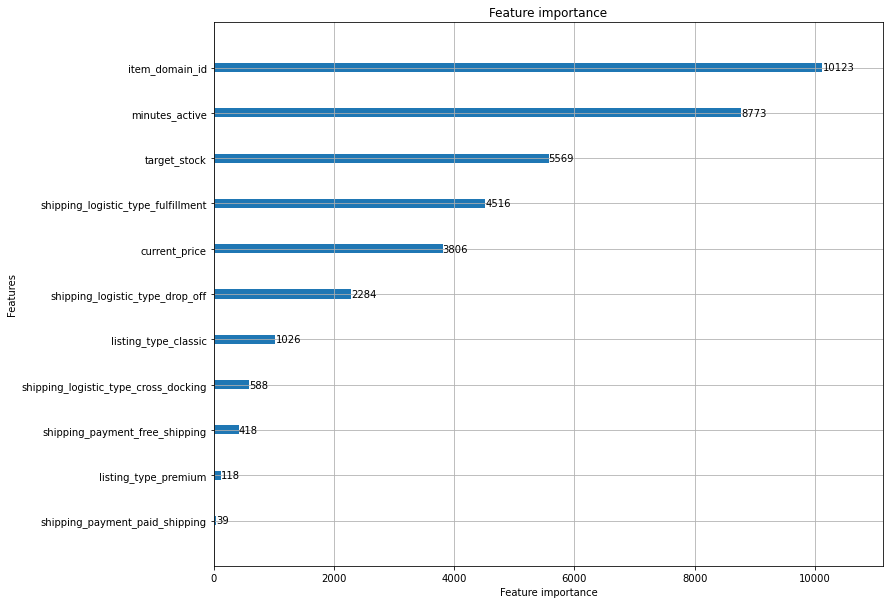

In [20]:
models_by_site = list()
sites = ["MLA","MLB","MLM"]

oof_preds = list()

for site in sites:
    print("-"*90)
    print(f"Preparing model for site: {site}")
    
    _train_dset = train_dset.query("site_id == @site").reset_index(drop=True)
    _valid_dset = valid_dset.query("site_id == @site").reset_index(drop=True)
    sample_index = _train_dset.sample(frac=0.25).index

    train_dset_lgb = lgb.Dataset(
        data = _train_dset.loc[:, numeric_cols+categs_cols],
        label= _train_dset.loc[:, target].values,
        categorical_feature = categs_cols,
        free_raw_data=False   
    )
    train_dset_sample_lgb = lgb.Dataset(
        data = _train_dset.loc[sample_index, numeric_cols+categs_cols],
        label= _train_dset.loc[sample_index, target].values,
        categorical_feature = categs_cols,
        free_raw_data=False   
    )
    valid_dset_lgb = lgb.Dataset(
        data = _valid_dset.loc[:, numeric_cols+categs_cols],
        label= _valid_dset.loc[:, target].values,
        categorical_feature = categs_cols,
        free_raw_data=False   
    )
    model = lgb.train(
        params = model_params,
        train_set = train_dset_lgb,
        valid_sets = [valid_dset_lgb, train_dset_sample_lgb],
        num_boost_round = 5000,
        early_stopping_rounds = 50,
        verbose_eval = 50,
    )

    lgb.plot_importance(model, importance_type="gain", figsize=(12,10))
    lgb.plot_importance(model, importance_type="split", figsize=(12,10))
    plt.show()
    
    _valid_dset["pred"] = model.predict(_valid_dset[numeric_cols+categs_cols])
    _valid_dset = binarize_predictions(_valid_dset)
    oof_preds.append(_valid_dset)
    models_by_site.append(model)

In [21]:
all_scores = list()

for site,model in zip(sites,models_by_site):
    print(site, "-", f"best_iteration: {model.best_iteration}", "-", f"best_score: {model.best_score['valid_0']['l1']}")
    all_scores.append(model.best_score['valid_0']['l1'])
    
print(f"AVG -  score: {np.mean(all_scores)}")

MLA - best_iteration: 777 - best_score: 5.585221096683179
MLB - best_iteration: 895 - best_score: 5.941561099990025
MLM - best_iteration: 1242 - best_score: 5.926445048810922
AVG -  score: 5.8177424151613755


***
## analysis of OOF predictions

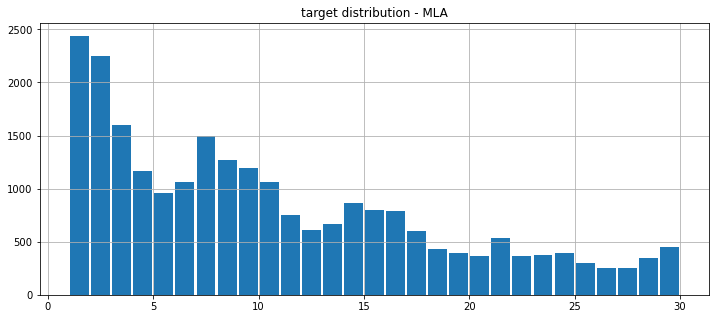

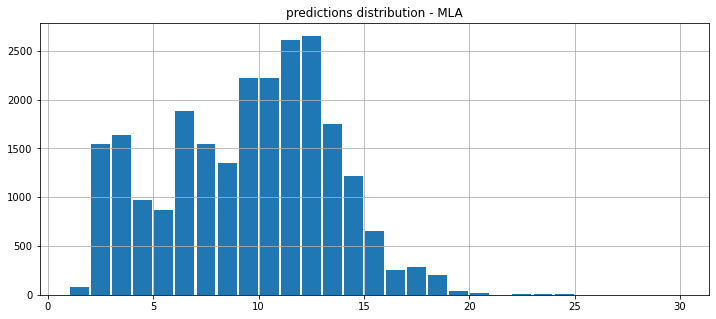

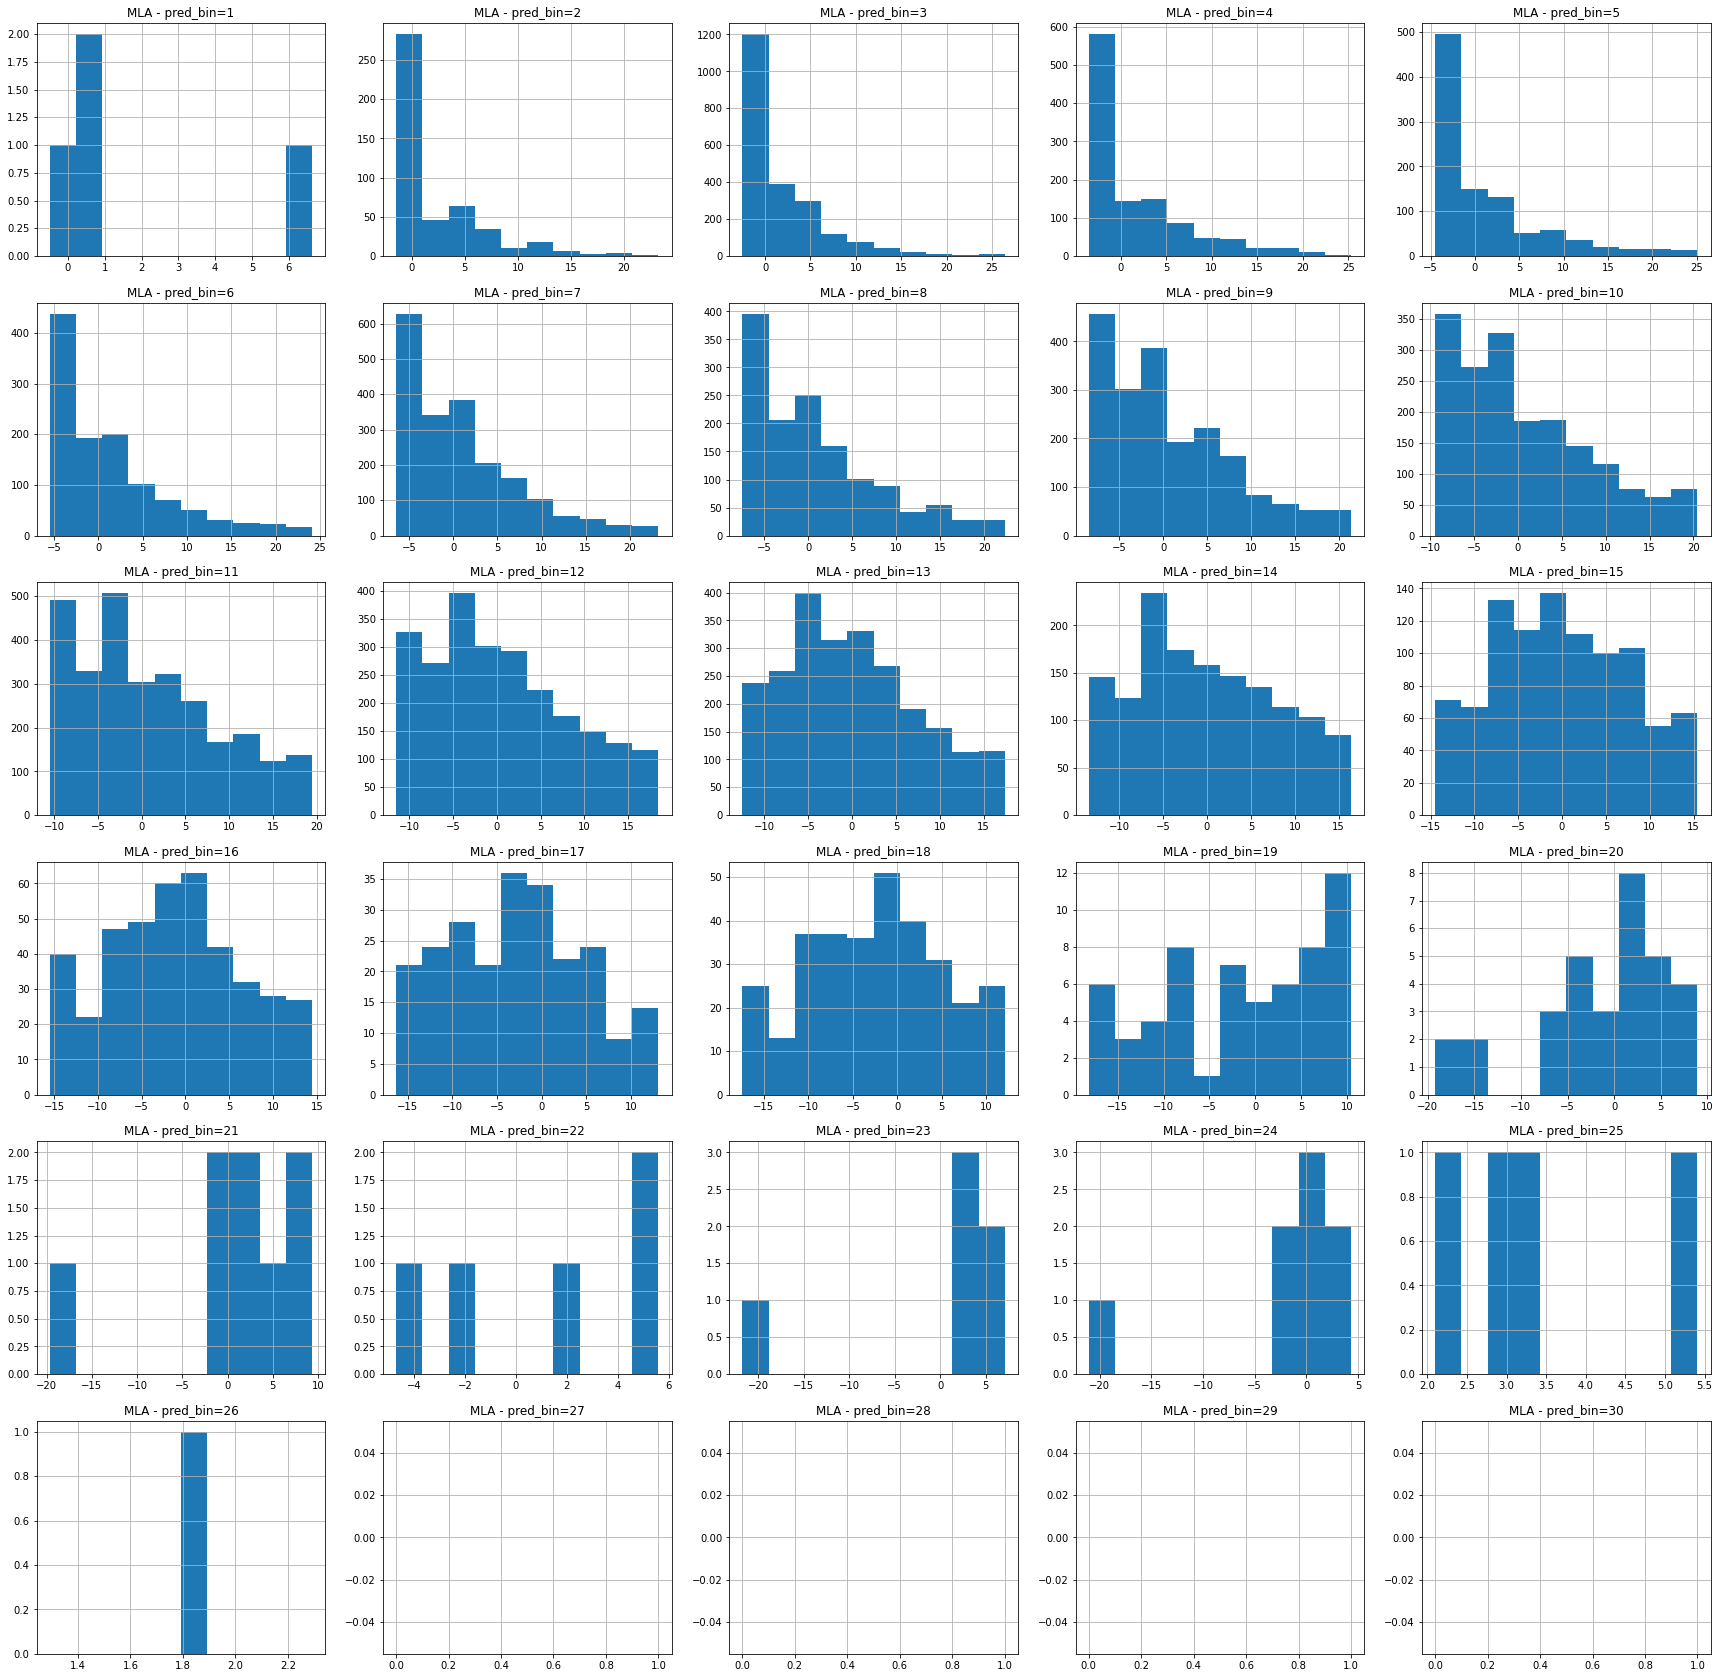

In [23]:
# results for MLA
plt.figure(figsize=(12,5))
plt.hist(oof_preds[0][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - MLA")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[0]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("predictions distribution - MLA")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[0].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"MLA - pred_bin={d}")
    plt.grid()
plt.show()

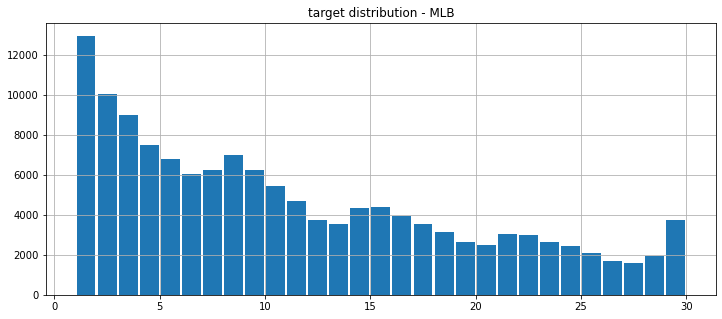

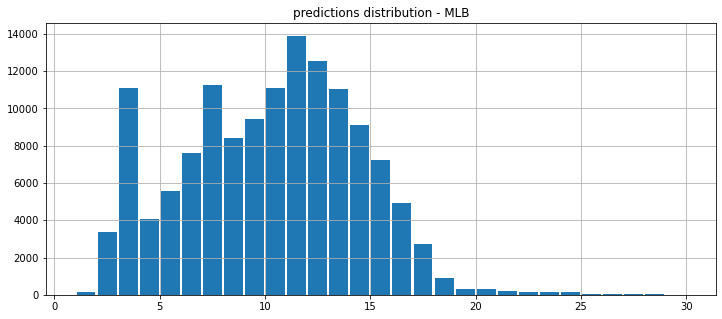

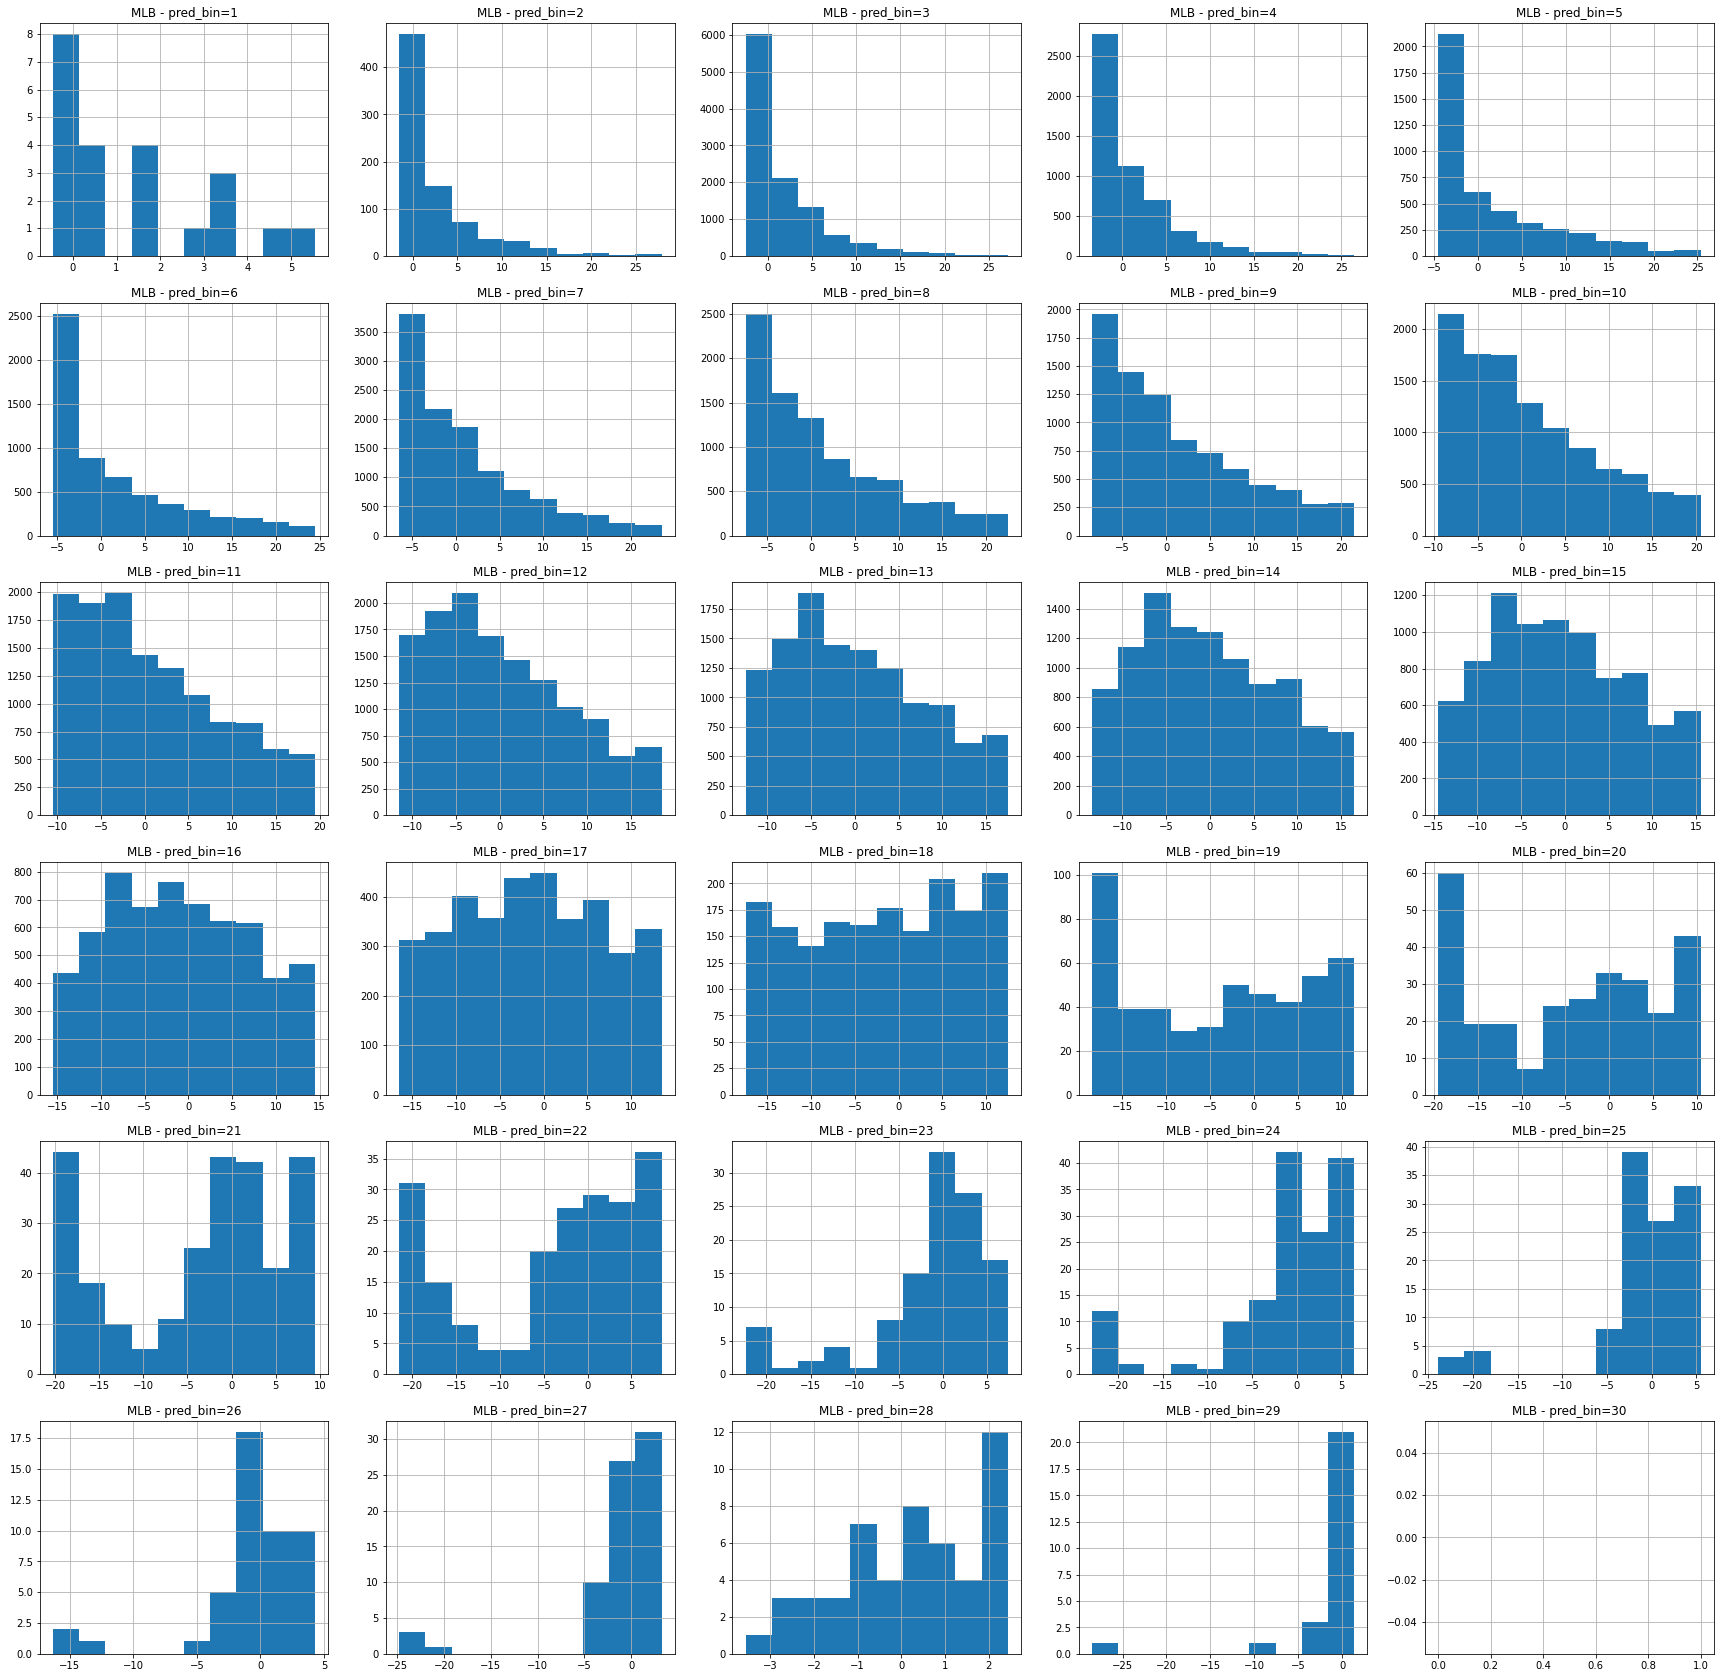

In [24]:
# results for MLB

plt.figure(figsize=(12,5))
plt.hist(oof_preds[1][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - MLB")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[1]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("predictions distribution - MLB")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[1].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"MLB - pred_bin={d}")
    plt.grid()
plt.show()

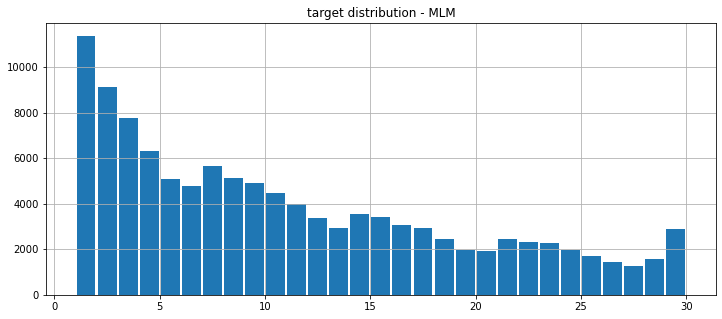

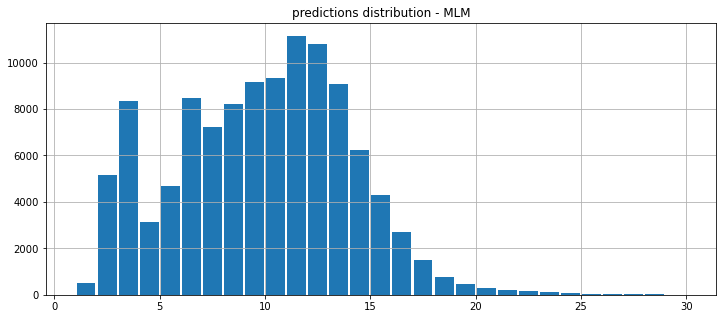

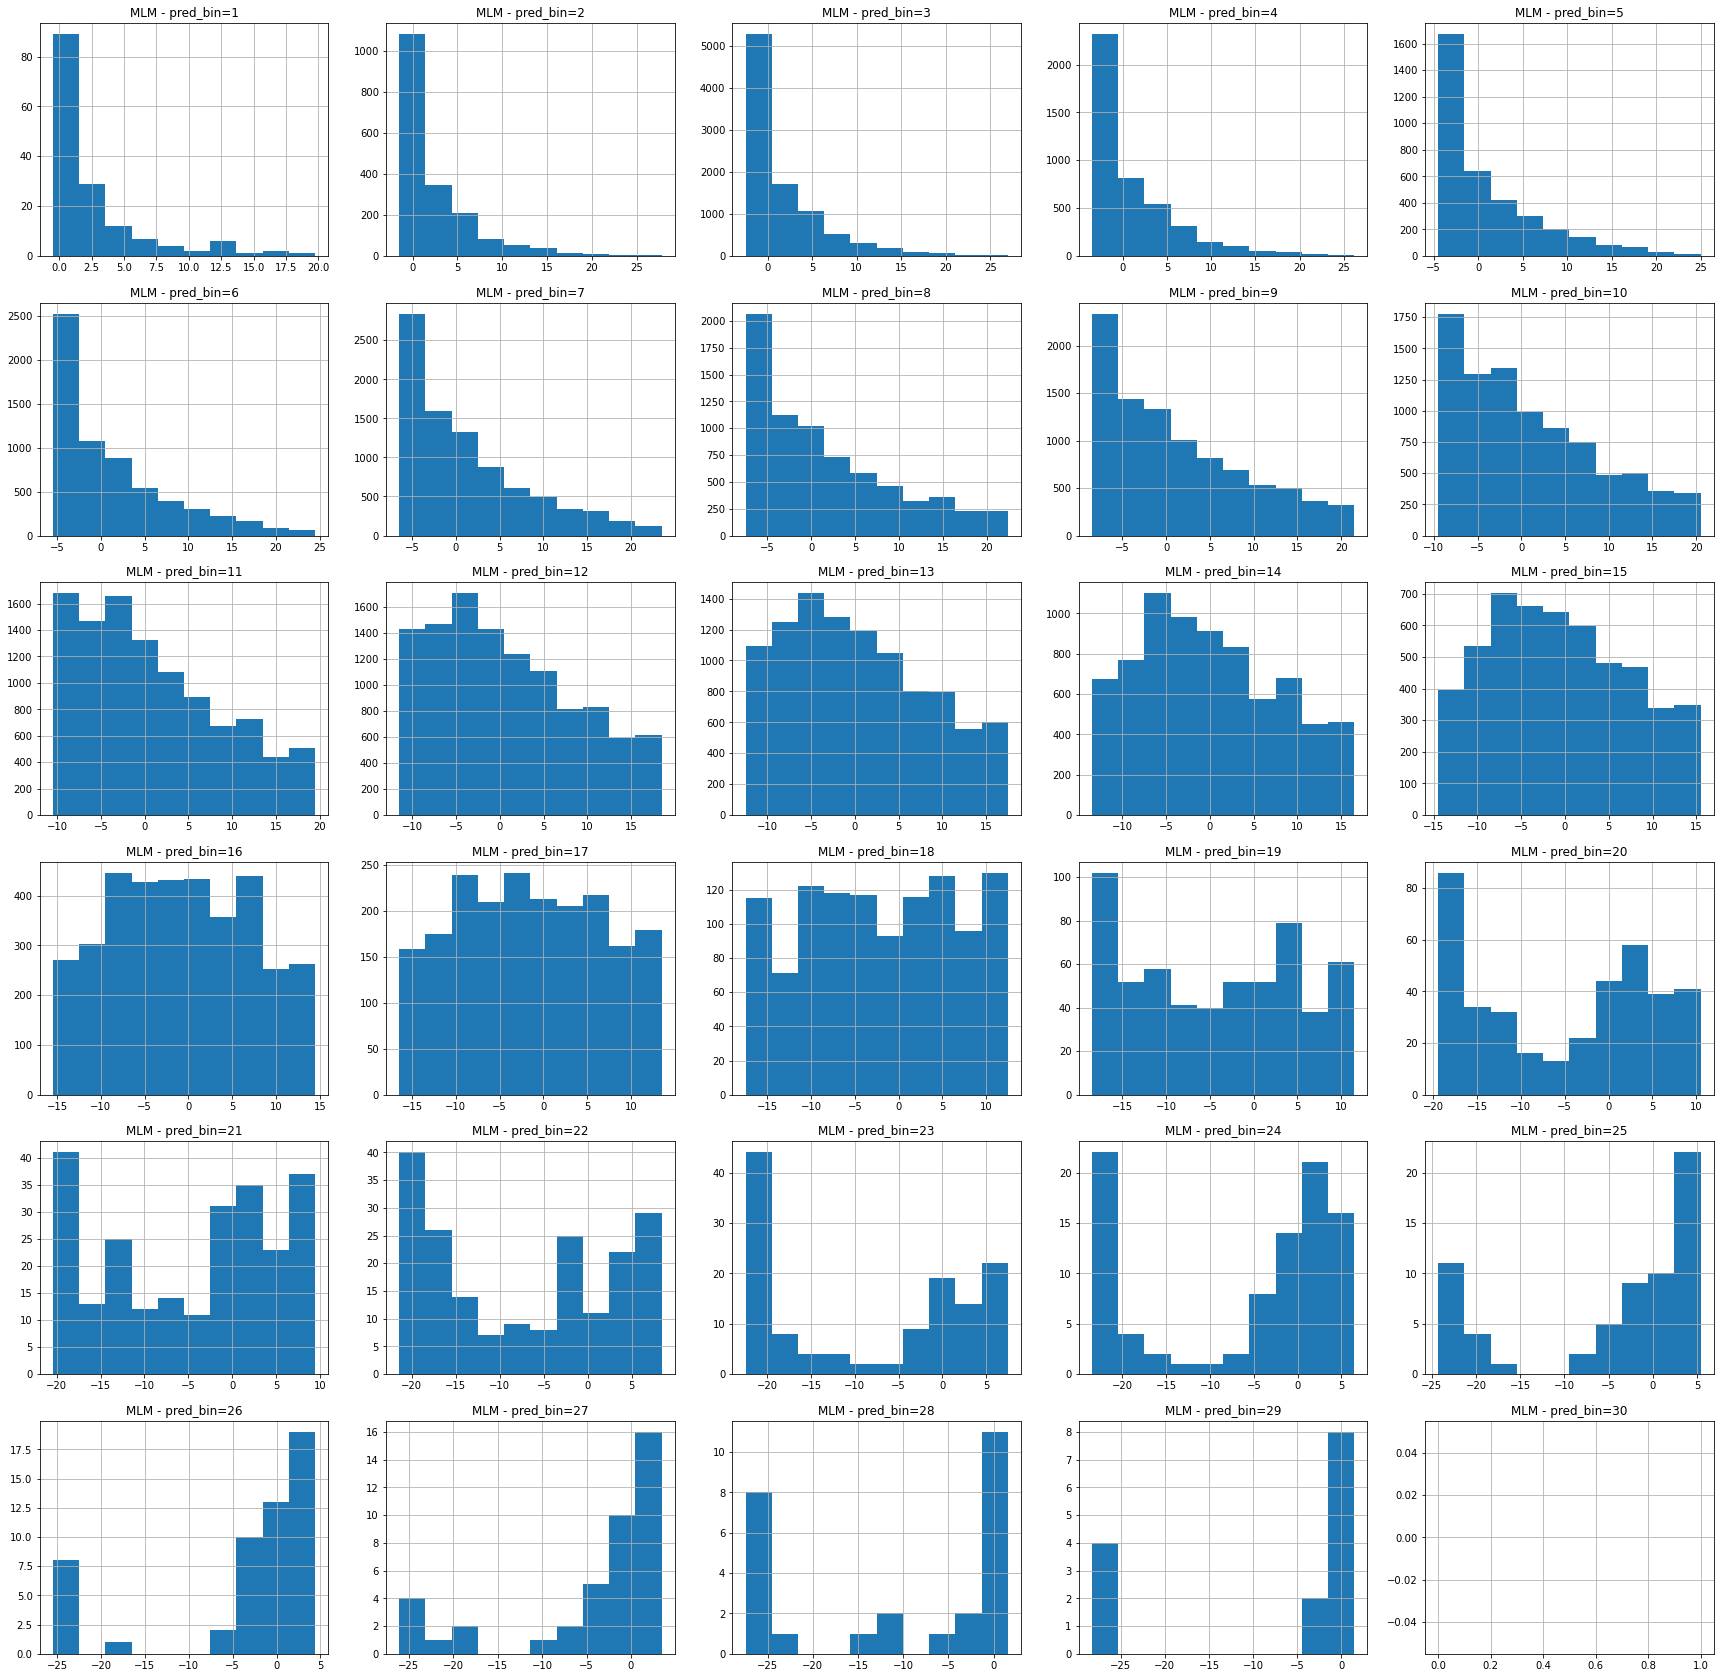

In [25]:
# results for MLM

plt.figure(figsize=(12,5))
plt.hist(oof_preds[2][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - MLM")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[2]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("predictions distribution - MLM")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[2].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"MLM - pred_bin={d}")
    plt.grid()
plt.show()

***
## model training

***